In [2]:
import networkx as nx
import pandas as pd
import numpy as np
from haversine import haversine, Unit
from torch_geometric.utils.convert import from_networkx, from_scipy_sparse_matrix
from torch_geometric_temporal.nn.recurrent import TGCN
import sys 
sys.path.append('..')
from utils import dataloader

/opt/homebrew/Caskroom/miniforge/base/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dist_matrix = pd.read_csv('../data/distance_matrix.csv')
dist_matrix.head()
df = dataloader.load_data()

In [4]:
def get_graph(data, adjecency_threshold_km=3):
    G = nx.Graph()

    for cluster in data['Cluster'].unique():
        if 'SHERMAN' in cluster:
            continue
        G.add_node(cluster)
        G.nodes[cluster]['ID'] = dist_matrix.columns.get_loc('WEBSTER')
        G.nodes[cluster]['lat'] = df[df['Cluster'] == cluster]['Latitude'].mean()
        G.nodes[cluster]['long'] = df[df['Cluster'] == cluster]['Longitude'].mean()
        G.nodes[cluster]['pos'] = (G.nodes[cluster]['long'], G.nodes[cluster]['lat'])


    for node_x in G.nodes:
        for node_y in G.nodes:
            dist = haversine(
                (G.nodes[node_x]['lat'], G.nodes[node_x]['long']),
                (G.nodes[node_y]['lat'], G.nodes[node_y]['long']),
                unit=Unit.KILOMETERS)
            if (dist > adjecency_threshold_km):
                continue
            G.add_edge(node_x, node_y)
            G[node_x][node_y]['weight'] = np.exp(-dist)


    adj = nx.adjacency_matrix(G)
    return G, adj
    #return G, normalize_adj(adj).todense()

In [5]:
G, adj = get_graph(df)
edge_index, edge_weight = from_scipy_sparse_matrix(adj)
edge_index, edge_weight, G.nodes

(tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
          4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
          7, 7, 7, 7, 7, 7],
         [0, 1, 2, 4, 5, 6, 7, 0, 1, 2, 4, 5, 6, 7, 0, 1, 2, 4, 5, 6, 7, 3, 6, 7,
          0, 1, 2, 4, 5, 6, 7, 0, 1, 2, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1,
          2, 3, 4, 5, 6, 7]]),
 tensor([1.0000, 0.7601, 0.7509, 0.1512, 0.6268, 0.1012, 0.0914, 0.7601, 1.0000,
         0.6967, 0.1174, 0.4962, 0.0945, 0.0881, 0.7509, 0.6967, 1.0000, 0.1272,
         0.6641, 0.0760, 0.0687, 1.0000, 0.0605, 0.0538, 0.1512, 0.1174, 0.1272,
         1.0000, 0.1769, 0.1420, 0.1073, 0.6268, 0.4962, 0.6641, 0.1769, 1.0000,
         0.0785, 0.0680, 0.1012, 0.0945, 0.0760, 0.0605, 0.1420, 0.0785, 1.0000,
         0.7429, 0.0914, 0.0881, 0.0687, 0.0538, 0.1073, 0.0680, 0.7429, 1.0000],
        dtype=torch.float64),
 NodeView(('HAMILTON', 'HIGH', 'BRYANT', 'MPL', 'RINCONADA', 'WEBSTER', 'TED', 'CAMBRIDGE')))

In [6]:
edge_weight.shape

torch.Size([54])

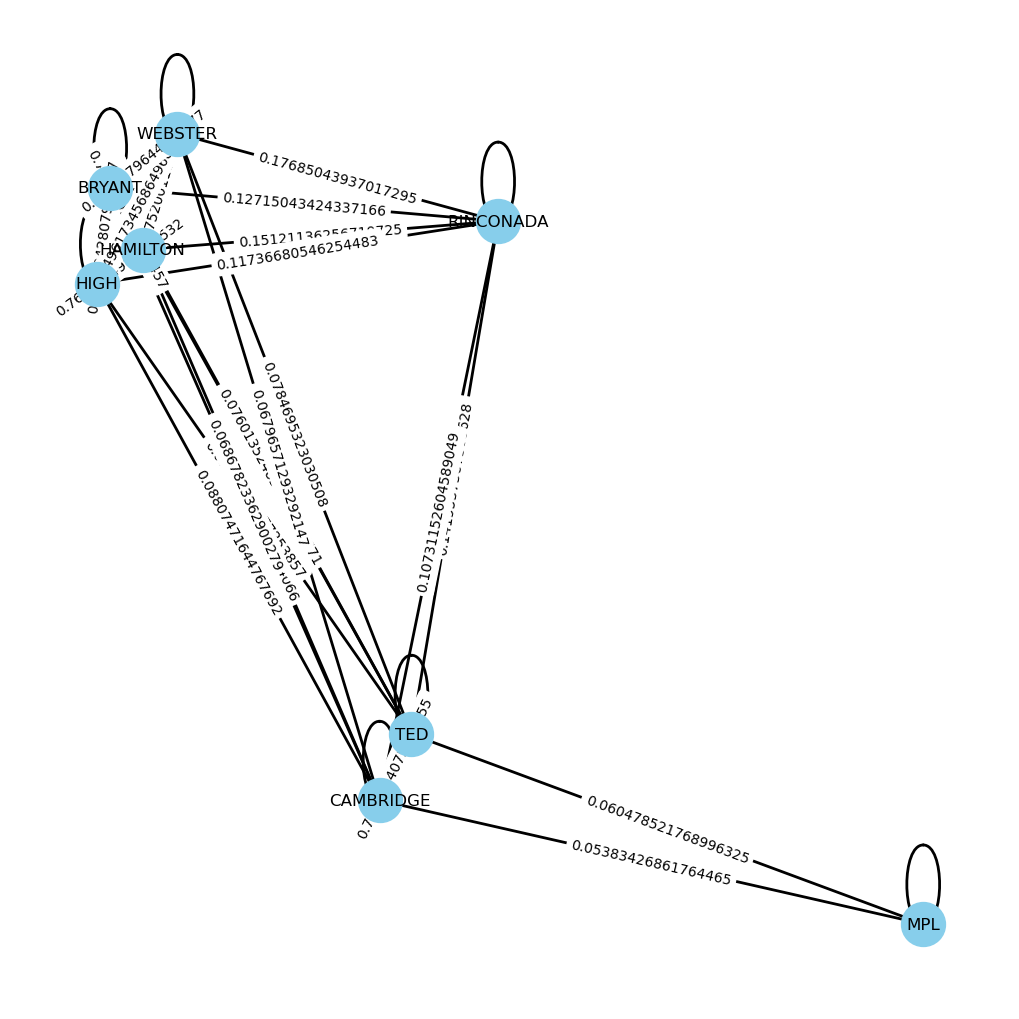

In [7]:
# plot graph
import matplotlib.pyplot as plt
import networkx as nx
# Plot graph with edge weights
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', edge_cmap=plt.cm.Blues, width=2)
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [8]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()
print(np.array(loader.features).shape)
print("snapshots:", len(loader.features))
print("nodes:", len(np.unique(loader._edges[0])))
print("lags:", np.array(loader.features).shape[2])
print("edges:", np.array(loader._edges).shape)
print("edge weights:", np.array(loader._edge_weights).shape)

(517, 20, 4)
snapshots: 517
nodes: 20
lags: 4
edges: (2, 102)
edge weights: (102,)


In [9]:
data = from_networkx(G)
data.edge_weight = edge_weight

In [10]:
df_sess = pd.read_csv('../data/charging_session_count_30.csv', parse_dates=['Period'])
df_sess

,Period,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER
0,2011-07-29 20:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2011-07-29 20:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2011-07-29 21:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2011-07-29 21:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2011-07-29 22:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
156657,2020-07-05 12:30:00,0.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0
156658,2020-07-05 13:00:00,0.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0
156659,2020-07-05 13:30:00,0.0,4.0,0.0,1.0,1.0,1.0,1.0,2.0
156660,2020-07-05 14:00:00,0.0,3.0,0.0,1.0,1.0,1.0,1.0,2.0


In [11]:
def get_targets_and_features_attention_tgcn(df, lags=30, add_month=True, add_week=True, add_day_of_week=True):
    df_test = df.copy()
    features = []
    # TODO make cos/sin encoded
    if add_month:
        df_test['month'] = df.Period.dt.month
        features.append('month')
    if add_day_of_week:
        df_test['dayofweek'] = df.Period.dt.dayofweek
        features.append('dayofweek')
    if add_week:
        df_test['week'] = df.Period.dt.isocalendar().week
        features.append('week')
    
    node_names = df_test.columns.difference(['Period'] + features)
    num_nodes = len(node_names)

    # Get initial lagged features
    sessions_array = np.array(df_test[node_names])
    lag_feats = np.array([
        sessions_array[i : i + lags, :].T
        for i in range(sessions_array.shape[0] - lags)
    ])
    lag_feats = lag_feats.reshape(-1, num_nodes, 1, lags)

    y = np.array([
        sessions_array[i + lags, :].T
        for i in range(sessions_array.shape[0] - lags)
    ])

    time_features = np.array(df_test[['dayofweek', 'month', 'week']], dtype=int)

    times = np.array([
        [time_features[i : i + lags, :].T]
        for i in range(time_features.shape[0] - lags)
    ])
    times = times.repeat(num_nodes, axis=1)
    
    # The `feat` matrix will go from (time_length, nodes, lags) to (time_length, nodes, number of features, lags)
    # We repeat the date-specific features 8 times because we have 8 nodes. 
    X = np.concatenate((lag_feats, times), axis=2)

    return X, y

In [12]:
feats, targets = get_targets_and_features_attention_tgcn(df_sess, lags=4, add_month=True, add_day_of_week=True, add_week=True)
time_length, nodes, feature_num, lag = feats.shape
print(f"Time length: {time_length}, Nodes: {nodes}, Features: {feature_num}, Lag: {lag}")
feats.shape

Time length: 156658, Nodes: 8, Features: 4, Lag: 4


(156658, 8, 4, 4)

In [13]:
def get_targets_and_features(df, lags=30, add_month=True, add_week=True, add_day_of_week=True):
    stacked_target = np.array(df_sess.drop(['Period'], axis=1))
    node_names = df.columns.difference(['Period'])
    # Get initial lagged features
    features = np.array([
        stacked_target[node_names][i : i + lags, :].T
        for i in range(stacked_target.shape[0] - lags)
    ])
    print(features.shape)

    targets = np.array([
        stacked_target[i + lags, :].T
        for i in range(stacked_target.shape[0] - lags)
    ])

    # The `feat` matrix will go from (time_length, nodes, lags) to (time_length, nodes, number of features, lags)
    # We repeat the date-specific features 8 times because we have 8 nodes. 
    # TODO make this cos encoded
    if add_month:
        features = np.concatenate((features, df.Period.dt.month.values.reshape(-1, 1,1)[lags:].repeat(8, axis=1)), axis=2) 
    if add_day_of_week:
        features = np.concatenate((features, df.Period.dt.dayofweek.values.reshape(-1, 1,1)[lags:].repeat(8, axis=1)), axis=2)
    if add_week:
        # This one has a weird pandas.arrays.IntegerArray type, so we need to convert it to a numpy array
        features = np.concatenate((features, df.Period.dt.isocalendar().week.to_numpy(dtype=int).reshape(-1, 1,1)[lags:].repeat(8, axis=1)), axis=2)

    return features, targets

In [15]:
from torch_geometric_temporal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

dataset = StaticGraphTemporalSignal(
        data.edge_index, data.edge_weight.float(), feats, targets
    )
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [22]:
import torch
import torch.nn.functional as F

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, hidden_dim, time_steps):
        super(RecurrentGCN, self).__init__()
        self.time_steps = time_steps
        self.recurrent = TGCN(node_features, hidden_dim)
        self.linear = torch.nn.Linear(hidden_dim, 1)


    def forward(self, x, edge_index, edge_weight):
        h = None # Maybe initialize randomly?
        for i in range(self.time_steps):
            h = self.recurrent(x[:,:,i], edge_index, edge_weight, h)
        #h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h.exp()

In [23]:
feats.shape

(156658, 8, 4, 4)

In [24]:
model = RecurrentGCN(node_features=4, hidden_dim=32, time_steps=lag)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.PoissonNLLLoss(log_input=False)
mean_absolute_error = torch.nn.L1Loss()
model.train()

# TODO Lav dataloader med X: (time, nodes, features), y: (time, nodes, 1), edge_index: (2, edges), edge_weight: (edges, 1)

for epoch in range(10):
    cost, mse = 0, 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_weight)
        cost += loss_func(y_hat, snapshot.y.view(-1,1))
        mse +=  mean_absolute_error(y_hat, snapshot.y.view(-1,1))
    cost = cost / (time+1)
    mse = mse / (time+1)
    print(f"Epoch {epoch}, cost {cost.item()}, mean_absolute_error: {mse}")
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

Epoch 0, cost 1.3196855783462524, mean_absolute_error: 1.275860071182251
Epoch 1, cost 0.7056796550750732, mean_absolute_error: 0.45711034536361694
Epoch 2, cost 0.6802219152450562, mean_absolute_error: 0.5104230046272278
Epoch 3, cost 0.677853524684906, mean_absolute_error: 0.5113818645477295
Epoch 4, cost 0.6761206984519958, mean_absolute_error: 0.4980488717556
Epoch 5, cost 0.6744482517242432, mean_absolute_error: 0.49800828099250793
Epoch 6, cost 0.6730499267578125, mean_absolute_error: 0.5077465772628784
Epoch 7, cost 0.6709762215614319, mean_absolute_error: 0.4995795488357544
Epoch 8, cost 0.6678822040557861, mean_absolute_error: 0.4867840111255646


tensor([1.0000, 0.7601, 0.7509, 0.1512, 0.6268, 0.1012, 0.0914, 0.7601, 1.0000,
        0.6967, 0.1174, 0.4962, 0.0945, 0.0881, 0.7509, 0.6967, 1.0000, 0.1272,
        0.6641, 0.0760, 0.0687, 1.0000, 0.0605, 0.0538, 0.1512, 0.1174, 0.1272,
        1.0000, 0.1769, 0.1420, 0.1073, 0.6268, 0.4962, 0.6641, 0.1769, 1.0000,
        0.0785, 0.0680, 0.1012, 0.0945, 0.0760, 0.0605, 0.1420, 0.0785, 1.0000,
        0.7429, 0.0914, 0.0881, 0.0687, 0.0538, 0.1073, 0.0680, 0.7429, 1.0000])

In [ ]:
data.edge_attr